# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [ ]:
!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-09-03 05:28:23--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  12.8MB/s    in 13s     

2021-09-03 05:28:36 (13.2 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-09-03 05:28:36--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  36.6MB/s    in 1.7s    

2021-09-03 05:28:38 (36.6 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-09-03 05:28:38--
Total wall clock time: 15s
Downloaded: 2 files, 235M in

In [ ]:
# First, lets load the dataset
data_train = dset.SVHN('./', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [ ]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

SVHN data sample shape:  torch.Size([3, 32, 32])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [ ]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1,momentum=0.9)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [ ]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):  
    # scheduler = lr_scheduler.StepLR(optimizer,1,0.5)

    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        # scheduler.step()

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    
    correct_samples = 0
    total_samples = 0
    model.eval()
     # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    for i_step, (x, y) in enumerate(val_loader):
      prediction = model(x)  
      _, indices = torch.max(prediction, 1)
      correct_samples += torch.sum(indices == y)
      total_samples += y.shape[0]
      val_accuracy = float(correct_samples) / total_samples
    return val_accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.634649, Train accuracy: 0.465225, Val accuracy: 0.538189
Average loss: 1.530745, Train accuracy: 0.514998, Val accuracy: 0.517303
Average loss: 1.529817, Train accuracy: 0.515817, Val accuracy: 0.504744


In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.525565, Train accuracy: 0.518002, Val accuracy: 0.534298
Average loss: 1.515050, Train accuracy: 0.521175, Val accuracy: 0.490751
Average loss: 1.530633, Train accuracy: 0.511978, Val accuracy: 0.510750


In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.541425, Train accuracy: 0.509146, Val accuracy: 0.519760
Average loss: 1.537581, Train accuracy: 0.508685, Val accuracy: 0.511569
Average loss: 1.521779, Train accuracy: 0.518223, Val accuracy: 0.536755


In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.528642, Train accuracy: 0.512797, Val accuracy: 0.499283
Average loss: 1.537189, Train accuracy: 0.512900, Val accuracy: 0.480035
Average loss: 1.532366, Train accuracy: 0.513122, Val accuracy: 0.503447


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [ ]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
       )
nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.187663, Train accuracy: 0.197215, Val accuracy: 0.223261
Average loss: 1.988946, Train accuracy: 0.287291, Val accuracy: 0.351102
Average loss: 1.787679, Train accuracy: 0.380354, Val accuracy: 0.405365
Average loss: 1.707302, Train accuracy: 0.415623, Val accuracy: 0.434714
Average loss: 1.683254, Train accuracy: 0.430997, Val accuracy: 0.437376


Добавьте слой с Batch Normalization

In [ ]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.049915, Train accuracy: 0.322237, Val accuracy: 0.442359
Average loss: 1.767848, Train accuracy: 0.481623, Val accuracy: 0.537711
Average loss: 1.629050, Train accuracy: 0.553834, Val accuracy: 0.592792
Average loss: 1.537087, Train accuracy: 0.593540, Val accuracy: 0.606853
Average loss: 1.470132, Train accuracy: 0.622496, Val accuracy: 0.648283


Добавьте уменьшение скорости обучения по ходу тренировки.

In [ ]:
from torch.optim import lr_scheduler
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

In [ ]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):  
    scheduler = lr_scheduler.StepLR(optimizer,1,0.5)

    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        scheduler.step()

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    
    correct_samples = 0
    total_samples = 0
    model.eval()
     # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    for i_step, (x, y) in enumerate(loader):
      prediction = model(x)  
      _, indices = torch.max(prediction, 1)
      correct_samples += torch.sum(indices == y)
      total_samples += y.shape[0]
      val_accuracy = float(correct_samples) / total_samples
    return val_accuracy

In [ ]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!del, train_loader, val_loader, loss, optimizer, 5)

In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.350667, Train accuracy: 0.682302, Val accuracy: 0.691352
Average loss: 1.350945, Train accuracy: 0.678651, Val accuracy: 0.697017
Average loss: 1.348994, Train accuracy: 0.681295, Val accuracy: 0.701522
Average loss: 1.346853, Train accuracy: 0.682831, Val accuracy: 0.699884


KeyboardInterrupt: ignored

In [ ]:
nn_model, optimizer

(Sequential(
   (0): Flattener()
   (1): Linear(in_features=3072, out_features=100, bias=True)
   (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (3): ReLU(inplace=True)
   (4): Linear(in_features=100, out_features=100, bias=True)
   (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU(inplace=True)
   (7): Linear(in_features=100, out_features=10, bias=True)
 ), SGD (
 Parameter Group 0
     dampening: 0
     initial_lr: 0.001
     lr: 1.953125e-06
     momentum: 0
     nesterov: False
     weight_decay: 0.1
 ))

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [ ]:
class SubsetSampler(Sampler):
    """Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    sampler = SubsetSampler(indices)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         sampler=SubsetSampler(indices))
    model.eval() # Evaluation mode
    ground_truth = []
    predictions = []
    for i, (x,y) in enumerate(val_loader):
      # predictions.append(torch.max(model(x)))
      _, pred_class = torch.max(model(x),1)
      predictions += pred_class
      print(len(predictions))

      ground_truth += y
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    # raise Exception("Not implemented")
    
    return predictions, ground_truth

# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
# print(len(predictions), len(val_indices))
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

![image.png](attachment:image.png)

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

In [90]:
from sklearn.metrics import confusion_matrix

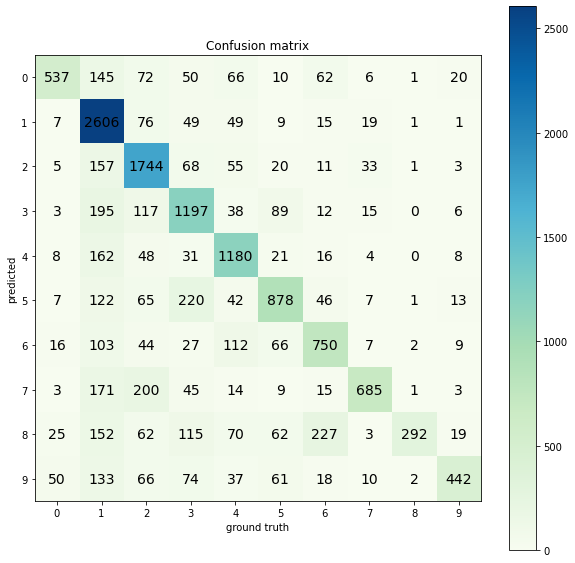

In [91]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    # confusion_matrix = np.zeros((10,10), np.int)
    conf_matrix = confusion_matrix(ground_truth,predictions)
    # TODO: Implement filling the prediction matrix
    return conf_matrix

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

2
19


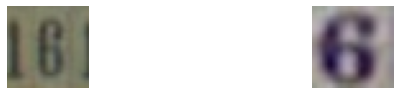

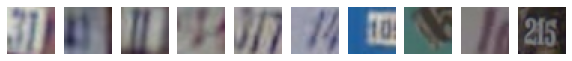

In [71]:
data_train_images = dset.SVHN('./', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """
    # indicies_needed = val_indices[(predictions==predicted_class)&(groud_truth==gt_class)]
    predictions = np.array([i.item() for i in predictions])
    groud_truth = np.array([i.item() for i in groud_truth])
    indicies_needed = val_indices[(predictions==predicted_class)&(groud_truth==gt_class)]
    print(((predictions==gt_class)&(groud_truth==predicted_class)).sum())
    visualize_images(indicies_needed,data)
    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    # raise Exception("Not implemented")

visualize_predicted_actual(6, 8, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [ ]:
# Experiment here!

In [ ]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

In [78]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):  
    scheduler = lr_scheduler.StepLR(optimizer,1,0.5)

    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        scheduler.step()

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    
    correct_samples = 0
    total_samples = 0
    model.eval()
     # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    for i_step, (x, y) in enumerate(loader):
      prediction = model(x)  
      _, indices = torch.max(prediction, 1)
      correct_samples += torch.sum(indices == y)
      total_samples += y.shape[0]
      val_accuracy = float(correct_samples) / total_samples
    return val_accuracy

In [84]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 200),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(200),
            nn.Linear(200, 100), 
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100), 
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 200), 
            nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 1.607461, Train accuracy: 0.491178, Val accuracy: 0.604054
Average loss: 1.288339, Train accuracy: 0.643671, Val accuracy: 0.645758
Average loss: 1.220667, Train accuracy: 0.693478, Val accuracy: 0.691147
Average loss: 1.163601, Train accuracy: 0.725779, Val accuracy: 0.737561
Average loss: 1.125011, Train accuracy: 0.748609, Val accuracy: 0.754078
Average loss: 1.097032, Train accuracy: 0.764273, Val accuracy: 0.765682
Average loss: 1.078939, Train accuracy: 0.774392, Val accuracy: 0.768889
Average loss: 1.070072, Train accuracy: 0.776951, Val accuracy: 0.774213
Average loss: 1.064916, Train accuracy: 0.779528, Val accuracy: 0.776671
Average loss: 1.062084, Train accuracy: 0.781934, Val accuracy: 0.775374


In [85]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.7593


In [87]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 300),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(300),
            nn.Linear(300, 200), 
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(200),
            nn.Linear(200, 200), 
            nn.BatchNorm1d(200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 300), 
            nn.BatchNorm1d(300),
            nn.ReLU(inplace=True),
            nn.Linear(300, 10)
         )

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 10)

Average loss: 1.494185, Train accuracy: 0.532488, Val accuracy: 0.584738
Average loss: 1.171776, Train accuracy: 0.686073, Val accuracy: 0.711283
Average loss: 1.092546, Train accuracy: 0.744514, Val accuracy: 0.752918
Average loss: 1.035909, Train accuracy: 0.779545, Val accuracy: 0.792369
Average loss: 0.993367, Train accuracy: 0.805122, Val accuracy: 0.813392
Average loss: 0.965009, Train accuracy: 0.821366, Val accuracy: 0.822742
Average loss: 0.947713, Train accuracy: 0.831434, Val accuracy: 0.827043
Average loss: 0.938899, Train accuracy: 0.836092, Val accuracy: 0.826974
Average loss: 0.931996, Train accuracy: 0.841023, Val accuracy: 0.829227
Average loss: 0.930601, Train accuracy: 0.841654, Val accuracy: 0.829158


In [88]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8067
